# Jax GIG implementation

Yoshii+ (2013) uses same parametrization as [Wikipedia](https://en.wikipedia.org/wiki/Generalized_inverse_Gaussian_distribution).

There is a reference implementation at Scipy: [`scipy.stats.geninvgauss.entropy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geninvgauss.html) which we test against.

- Note: its differential `entropy()` actually uses quadrature; we use analytical formula from Wikipedia


In [ ]:
from bngif.gig import GIG
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as sp
from numpy.testing import assert_allclose

In [85]:
# ---------------------------------------------------------------------
# 1)   Compare our closed-form moments to SciPy when  a == b
# ---------------------------------------------------------------------
def test_against_scipy_geninvgauss():
    rng = np.random.default_rng(0)

    for _ in range(20):
        p = float(rng.uniform(1.2, 5.0))  # mean exists for p>1
        b = float(rng.uniform(0.1, 6.0))  # a == b here
        g = GIG(p=p, a=b, b=b)

        mean_jax, inv_jax, log_jax = g.moments()

        # SciPy reference via .to_scipy()
        rv = g.to_scipy()
        mean_ref = rv.mean()
        inv_ref = rv.expect(lambda x: 1.0 / x)
        log_ref = rv.expect(np.log)

        assert_allclose(mean_jax, mean_ref, rtol=1e-11, atol=1e-13)
        assert_allclose(inv_jax, inv_ref, rtol=1e-8, atol=1e-13)
        assert_allclose(log_jax, log_ref, rtol=1e-7, atol=1e-11)


test_against_scipy_geninvgauss()


In [ ]:
# ---------------------------------------------------------------------
# 2)   Inverse-Gaussian special case   (p = −½,  b = 1/μ,  scale = μ)
#       E[X] should equal μ
# ---------------------------------------------------------------------
def test_inverse_gaussian_mean():
    mu = 2.0
    p, b = -0.5, 1.0 / mu
    g = GIG(p=p, a=b, b=b)  # Y ~ GIG scale=1
    mean_y, *_ = g.moments()
    mean_x = mu * float(mean_y)  # X = μ·Y

    scipy_mean = sp.invgauss(mu).mean()
    assert_allclose(mean_x, scipy_mean, rtol=1e-11, atol=1e-13)


test_inverse_gaussian_mean()

In [ ]:
# ---------------------------------------------------------------------
# 3)   Gamma limit:  b → 0⁺  ⇒  GIG(p,a,b) →  Gamma(k=p, θ=2/a)
# ---------------------------------------------------------------------
from bngif.gig import Gamma


def test_gamma_subclass():
    rng = np.random.default_rng(321)

    for _ in range(10):
        k = rng.uniform(1.2, 6.0)  # shape (k>1 ⇒ finite entropy)
        rate = rng.uniform(0.4, 5.0)  # λ
        g = Gamma(shape=k, rate=rate, eps=1e-10)

        mean, inv, log = g.moments()
        H = g.entropy()

        rv = g.to_scipy()
        assert_allclose(mean, rv.mean(), rtol=1e-8)
        assert_allclose(H, rv.entropy(), rtol=1e-8)

        # gradients wrt shape & rate are finite
        dH_dshape = jax.grad(lambda s: Gamma(s, rate).entropy())(k)
        dH_drate = jax.grad(lambda r: Gamma(k, r).entropy())(rate)
        assert np.isfinite(dH_dshape) and np.isfinite(dH_drate)


test_gamma_subclass()

0.9990863876102997 0.9981766545337837 0.9996592109016663
0.9993974153623231 1.0010280914499383 1.0031758139163447
1.0031671765269876 0.9977408072156023 0.989901503001472
1.0034197538290008 1.0004358238472406 1.00240593103265
0.9959357815880137 1.0038652771409877 1.0071785322729705
0.9990359940575737 0.9975784756640106 0.9993672826686144
0.9993737417066155 1.0013868267498878 0.9994457875748625
1.0018523834458133 0.9995965991722869 1.0185842519266606
1.0004997213818247 1.0139331796880646 1.0019428924391256
1.0003252210858016 1.0002250179810597 1.0004716224533015


In [ ]:
# ---------------------------------------------------------------------
# 4)   Reciprocal property:  X~GIG(p,a,b)  ⇒  1/X ~ GIG(−p,b,a)
# ---------------------------------------------------------------------
def test_reciprocal_identity():
    p, a, b = 1.8, 2.0, 0.7
    mean_x, mean_invx, _ = GIG(p=p, a=a, b=b).moments()
    mean_x_recip, *_ = GIG(p=-p, a=b, b=a).moments()

    assert_allclose(mean_invx, mean_x_recip, rtol=1e-12, atol=1e-14)


test_reciprocal_identity()

In [ ]:
# ---------------------------------------------------------------------
# 5)   Entropy: closed-form vs SciPy numeric integration
#      + jit- and grad- friendliness
# ---------------------------------------------------------------------
from bngif.gig import entropy as gig_entropy


def test_entropy_and_autodiff():
    rng = np.random.default_rng(42)

    # use a handful of random parameter triples that keep SciPy quadrature cheap
    for _ in range(5):
        p = float(rng.uniform(0.4, 3.0))  # finite entropy, away from tails
        a = float(rng.uniform(0.2, 4.0))
        b = float(rng.uniform(0.2, 4.0))
        g = GIG(p=p, a=a, b=b)

        # --- reference via SciPy numeric integration -----------------
        entropy_ref = g.to_scipy().entropy()

        # --- our closed form ----------------------------------------
        entropy_val = g.entropy()
        assert_allclose(entropy_val, entropy_ref, rtol=1e-6, atol=1e-7)

        # --- jit works ---------------------------------------------
        entropy_jit = jax.jit(gig_entropy)
        assert_allclose(entropy_jit(p, a, b), entropy_val, rtol=1e-9, atol=1e-9)

        # --- gradients wrt a and b exist and are finite ------------
        grad_a = jax.grad(lambda aa: gig_entropy(p, aa, b))(a)
        grad_b = jax.grad(lambda bb: gig_entropy(p, a, bb))(b)

        for gval in (grad_a, grad_b):
            assert np.isfinite(gval), "NaN/Inf gradient detected"


test_entropy_and_autodiff()

Plot the PDF on the three scales $x,1/x,\log x$. Note $1/x \sim GIG(-p,a,b)$ -- simple negation of order $p$.


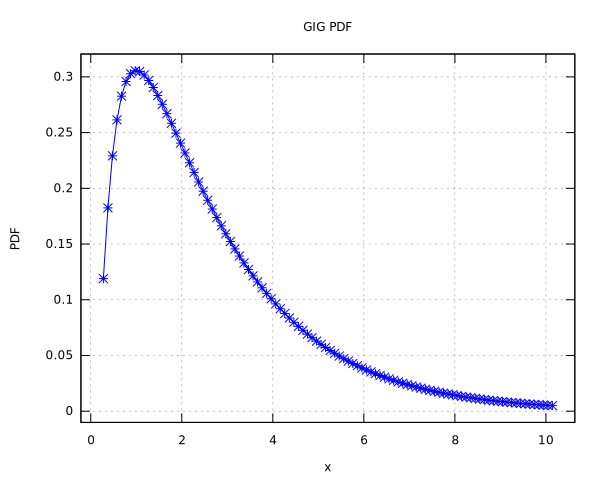

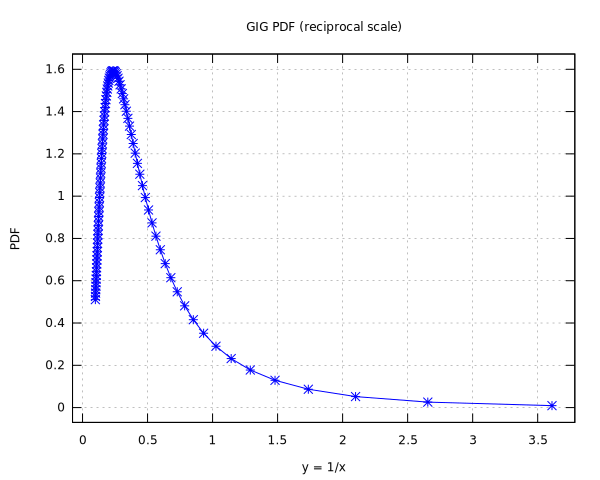

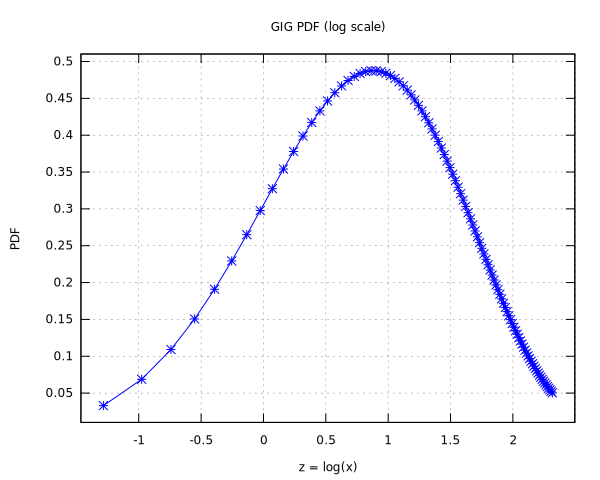

In [ ]:
from utils.plotting import iplot

gig = GIG(p=1.0, a=1.0, b=1.0).to_scipy()

x = np.linspace(gig.ppf(0.01), gig.ppf(0.99), 100)
y = 1 / x
z = np.log(x)


def pdfx(x):
    return gig.pdf(x)


def pdfy(y):
    return gig.pdf(1 / y) * (1 / y**2)  # Jacobian for change of variables


def pdfz(z):
    return gig.pdf(np.exp(z)) * np.exp(z)


iplot(x, pdfx(x), title="GIG PDF", xlabel="x", ylabel="PDF")
iplot(y, pdfy(y), title="GIG PDF (reciprocal scale)", xlabel="y = 1/x", ylabel="PDF")
iplot(z, pdfz(z), title="GIG PDF (log scale)", xlabel="z = log(x)", ylabel="PDF")


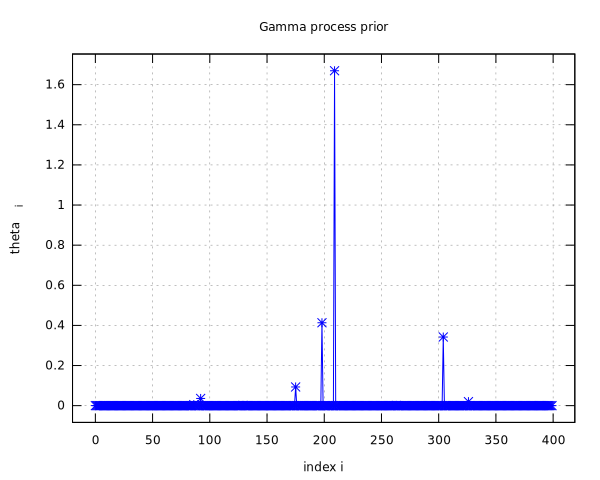

In [60]:
import jax
import jax.numpy as jnp

I = 400
alpha = 1.0

iplot(
    Gamma(alpha / I, alpha).to_scipy().rvs(I),
    title="Gamma process prior",
    xlabel="index i",
    ylabel="theta_i",
)

In [91]:
a_w = b_w = 1.0
a_e = b_e = 1.0

z = {
    "nu_w": Gamma(a_w, b_w),
    "nu_e": Gamma(a_e, b_e),
    "theta": Gamma(jnp.ones(I) * alpha / I, alpha),
}

In [92]:
is_gig = lambda x: isinstance(x, GIG)


entropies = jax.jit(
    lambda t: jax.tree_util.tree_map(
        lambda d: d.entropy(),
        t,
        is_leaf=is_gig,
    )  # <-- Don't unflatten GIG
)

entropies(z)

{'nu_e': Array(0.30685282, dtype=float64, weak_type=True),
 'nu_w': Array(0.30685282, dtype=float64, weak_type=True),
 'theta': Array([-394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394.27229859,
        -394.27229859, -394.27229859, -394.27229859, -394